In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df =pd.read_csv('/content/drive/MyDrive/dataFile/synthetic_dataset.csv')
print(df)

     feature1  feature2  feature3  feature4  target
0    1.248357  2.357787  2.074098  1.279545       1
1    0.930868  2.560785  1.367035  2.590535       0
2    1.323844  3.083051  0.281877  1.403255       3
3    1.761515  3.053802  4.323612  1.327312       1
4    0.882923  0.622331  4.064505  1.328532       0
..        ...       ...       ...       ...     ...
195  1.192659  1.530824  0.906165  1.974862       2
196  0.558071  0.286865  0.332481  2.789104       2
197  1.076863  3.353872  3.705603  2.599711       0
198  1.029104  1.885460  2.872366  1.850427       1
199  0.428515  3.237816  4.209144  1.044939       2

[200 rows x 5 columns]


In [ ]:
features = ['feature1','feature2','feature3','feature4']
X = df[features]
Y = df[['target']].values

In [ ]:
# Manual Min-Max Scaling for input features
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

Y_min = Y.min(axis=0)
Y_max = Y.max(axis=0)
Y_scaled = (Y - Y_min) / (Y_max - Y_min + 1e-8)

The code performs manual Min-Max scaling to normalize input (X) and output (Y) features to a [0, 1] range.

In [ ]:
def train_test_split(X, Y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    # Use .iloc for integer-location based indexing in pandas DataFrames
    return X.iloc[train_indices], X.iloc[test_indices], Y[train_indices], Y[test_indices]

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=8)
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

Using a specified ratio, the train_test_split function divides the incoming data into training and testing sets.  The outcomes are repeatable if random_state is set.  It chooses subsets, shuffles indices, and indexes using.iloc.  Following splitting, class labels are extracted from the scaled outputs using np.argmax().

In [ ]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 4
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 8
        hiddenLayer3Neurons = 5
        outLayerNeurons = 4

        self.learning_rate = 0.005
        self.W_HI = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_HI1 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_HI2 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outLayerNeurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        self.input = X
        self.hidden_input = np.dot(X, self.W_HI)
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.hidden_input1 = np.dot(self.hidden_output, self.W_HI1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W_HI2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.output_input = np.dot(self.hidden_output2, self.W_OH)
        self.pred = self.sigmoid(self.output_input)
        return self.pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred  # Error from the final output
        output_delta = output_error * self.sigmoid(pred, True) #removed learning rate from here

        hidden3_error = output_delta.dot(self.W_OH.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.sigmoid(self.hidden_output2, True) #changed hidden3_output to hidden_output2

        hidden2_error = hidden3_delta.dot(self.W_HI2.T)  # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.sigmoid(self.hidden_output1, True) #changed hidden2_output to hidden_output1

        hidden1_error = hidden2_delta.dot(self.W_HI1.T)  # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.sigmoid(self.hidden_output, True) #changed hidden1_output to hidden_output

        # Adjusting the weights - added learning rate here
        self.W_OH += self.hidden_output2.T.dot(output_delta) * self.learning_rate
        self.W_HI2 += self.hidden_output1.T.dot(hidden3_delta) * self.learning_rate
        self.W_HI1 += self.hidden_output.T.dot(hidden2_delta) * self.learning_rate
        self.W_HI += X.T.dot(hidden1_delta) * self.learning_rate


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

A feedforward neural network with three hidden layers is defined by the NeuralNetwork class. It employs backpropagation to update weights and the sigmoid activation function. While backPropagation modifies weights based on errors, the feedForward approach calculates predictions. The train approach uses both to complete a single training step.

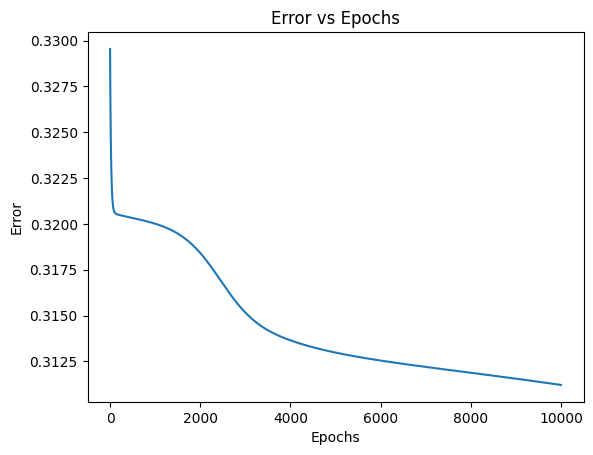

In [ ]:
NN = NeuralNetwork()

err = []
for i in range(10000):
  NN.train(X_train, Y_train)
  err.append(np.mean(np.abs(Y_train - NN.feedForward(X_train))))
plt.plot(err)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error vs Epochs")
plt.show()

While the neural network was effective in classifying Class 1, it was unable to classify Classes 2, 3, and 4. The neural network, which was trained to classify four classes, had a poor overall accuracy of roughly 0.40, with significant performance variation among classes.  This result points to issues including possible data imbalance, ineffective network design and hyperparameter selection, sigmoid activation in hidden layers, and the use of a wide range of assessment measures in addition to overall accuracy.

In [ ]:

def target(pred):
    predicted_class = np.argmax(pred, axis=1)
    target = predicted_class + 1
    return target

predictions = NN.feedForward(X_test)
Y_pred = target(predictions)

print(Y_pred)

[2 1 3 1 3 2 1 3 3 4 3 1 1 4 3 1 3 1 1 1 3 3 3 3 1 3 1 4 1 3 1 1 1 4 4 3 3
 4 1 4]


In [ ]:

def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

Y_test_original = (Y_test * (Y_max - Y_min) + Y_min).astype(int)
Y_test_target = target(Y_test_original)

acc = accuracy(Y_test_target, Y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.4


In [ ]:
predictions_test_probabilities = NN.feedForward(X_test)
predictions_test_labels = np.argmax(predictions_test_probabilities, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fp = np.sum((y_true != class_label) & (y_pred == class_label))
    return tp / (tp + fp + 1e-8)

def recall(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fn = np.sum((y_true == class_label) & (y_pred != class_label))
    return tp / (tp + fn + 1e-8)

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

overall_accuracy = accuracy(Y_test_labels, predictions_test_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

for i in range(4):
    prec = precision(Y_test_labels, predictions_test_labels, i)
    rec = recall(Y_test_labels, predictions_test_labels, i)
    f1 = f1_score(prec, rec)
    print(f"Class {i+1}:")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Overall Accuracy: 0.4000
Class 1:
  Precision: 1.0000
  Recall: 0.4000
  F1-Score: 0.5714
Class 2:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 3:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 4:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


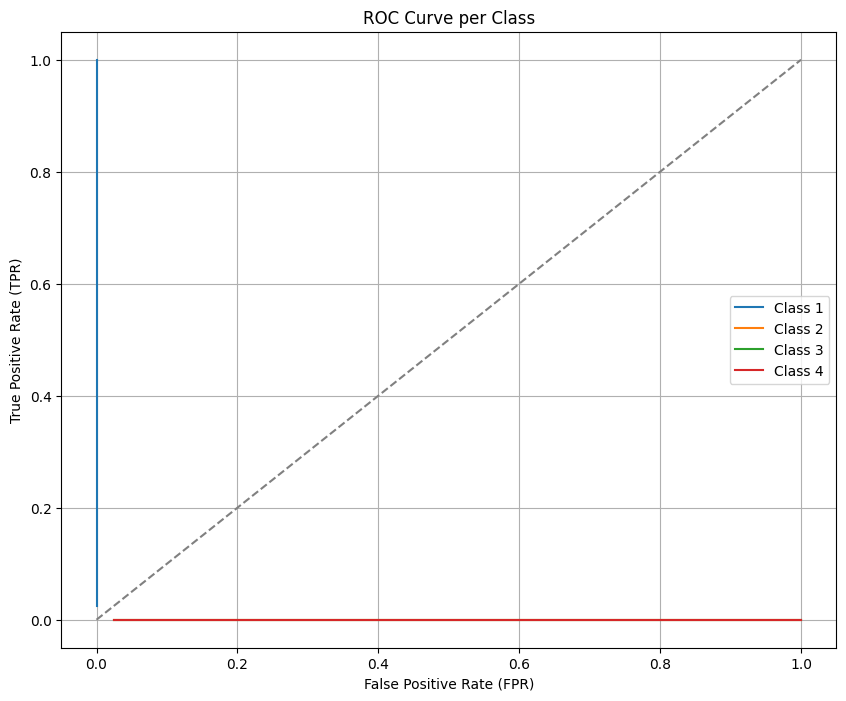

In [ ]:
def roc_curve_per_class(y_true, y_scores, num_classes):
    # Convert y_true to one-hot encoding if it's not already
    if y_true.shape[1] == 1:  # Check if y_true has only one column
        y_true_onehot = np.zeros((y_true.shape[0], num_classes))
        for i, val in enumerate(y_true.flatten()):
            y_true_onehot[i, int(val)] = 1  # Assuming y_true contains class labels 0 to num_classes-1
        y_true = y_true_onehot  # Replace y_true with one-hot encoded version

    fpr_all = []
    tpr_all = []
    for class_idx in range(num_classes):
        fpr = []
        tpr = []
        thresholds = sorted(np.unique(y_scores[:, class_idx]), reverse=True)
        for threshold in thresholds:
            y_pred = (y_scores[:, class_idx] >= threshold).astype(int)
            tp = np.sum((y_true[:, class_idx] == 1) & (y_pred == 1))
            fp = np.sum((y_true[:, class_idx] == 0) & (y_pred == 1))
            tn = np.sum((y_true[:, class_idx] == 0) & (y_pred == 0))
            fn = np.sum((y_true[:, class_idx] == 1) & (y_pred == 0))

            if (tp + fn) == 0:
                tpr_val = 0
            else:
                tpr_val = tp / (tp + fn)  # Sensitivity or True Positive Rate

            if (fp + tn) == 0:
                fpr_val = 0
            else:
                fpr_val = fp / (fp + tn)  # False Positive Rate
            fpr.append(fpr_val)
            tpr.append(tpr_val)
        fpr_all.append(fpr)
        tpr_all.append(tpr)

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr_all[i], tpr_all[i], label=f'Class {i + 1}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fpr_all, tpr_all

fpr_all, tpr_all = roc_curve_per_class(Y_test, predictions, 4)